# Malaria Detection Using Deep Learning in TensorFlow

## Introduction

In this tutorial, we will explore how to build a deep learning model for detecting malaria-infected cells using the **Malaria Dataset** from `tensorflow_datasets`. This project will walk through several approaches to improve model performance, including:

1. **Baseline CNN Model**
2. **Data Augmentation**
3. **Transfer Learning** with a pre-trained model
4. **Dropout** to prevent overfitting

By the end of this tutorial, you’ll be able to:
- Load and preprocess a dataset.
- Build and train deep learning models with TensorFlow.
- Use transfer learning to boost model performance.
- Implement data augmentation and dropout layers for better generalization.

### Prerequisites

Make sure you have the following libraries installed:

```bash
pip install tensorflow tensorflow-datasets matplotlib
```

If you want to use the GPU on Apple Silicon (M-Series), install the tensorflow-metal plugin:
```bash
pip install tensorflow-metal
```

In [33]:
! pip install tensorflow tensorflow-metal tensorflow-datasets matplotlib

### Importing Required Libraries

Let’s start by importing all the necessary libraries for the project. These include TensorFlow for model building and tensorflow_datasets for loading the Malaria dataset.

In [14]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

Now we can check what version of TensorFlow we are using and if the GPU is available.

In [15]:
# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Loading and Preprocessing the Dataset

The Malaria Dataset contains cell images categorized into two classes: parasitized (infected) and uninfected (healthy). We will load the dataset using tensorflow_datasets and split it into training, validation, and test sets.

In [16]:
# Load the Malaria dataset
# The dataset has two classes: parasitized and uninfected
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Get number of classes
num_classes = ds_info.features['label'].num_classes
print("Number of classes:", num_classes)

Number of classes: 2


### Preparing the Dataset for Performance

Next, we resize the images to 224x224 pixels and normalize the pixel values for efficient training. Later on we will be using transfer learning so we're going to make sure our data matches that right now. We will also configure the datasets for performance by shuffling, batching, and prefetching.

In [17]:
# Define constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Using 224x224 for compatibility with MobileNetV2
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    label = tf.cast(label, tf.float32)
    return image, label

# Apply preprocessing and prepare datasets
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

## 1. Building a Baseline CNN Model

We will first build a baseline Convolutional Neural Network (CNN) to establish a reference for model performance. This model includes three convolutional layers followed by a dense layer for classification.

In [19]:
# Build a simple CNN model
def create_baseline_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

baseline_model.summary()

/Users/jordanwhite/miniforge3/envs/Malaria/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling and Training the Model

We compile the model with binary_crossentropy as the loss function (since this is a binary classification task) and adam as the optimizer. We also add EarlyStopping to stop training when the validation loss stops improving.

In [20]:
# Train the baseline model
history_baseline = baseline_model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10


2024-09-17 13:01:44.075012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


603/603 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6672 - loss: 0.6324 - val_accuracy: 0.9354 - val_loss: 0.1755
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9390 - loss: 0.1878 - val_accuracy: 0.9523 - val_loss: 0.1497
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9537 - loss: 0.1380 - val_accuracy: 0.9511 - val_loss: 0.1551
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9625 - loss: 0.1056 - val_accuracy: 0.9473 - val_loss: 0.1676
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9738 - loss: 0.0738 - val_accuracy: 0.9470 - val_loss: 0.2033


### Check Results

Now we can look at how the baseline model performed as it trained. Notice how the Train Accuracy went up a lot but the Validation Accuracy didn’t improve much. This is evidence of overfitting, when the model learns the patterns and noise in the training data too well, resulting in high performance on the training set but poor generalization to unseen data, as reflected in the validation accuracy not improving.

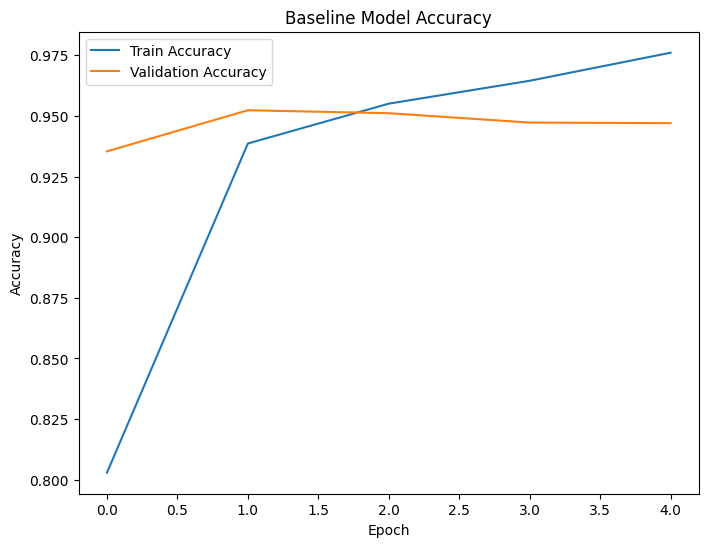

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history_baseline.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2. Training with Data Augmentation

How can we increase performance and stop our model from overfitting? We can use data augmentation, a powerful technique to artificially increase the size of your training set. We will apply random flips, rotations, and zooms to the training images to improve generalization.

In [23]:
# Define data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply data augmentation to the training dataset
def augment(image, label):
    image = data_augmentation(image)
    return image, label

ds_train_aug = ds_train.map(augment, num_parallel_calls=AUTOTUNE)

In [24]:
# Build the same baseline model
augmented_model = create_baseline_model()
augmented_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

augmented_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model with Augmented Data

We now retrain the CNN model using the augmented dataset.

In [25]:
# Train the model with augmented data
history_augmented = augmented_model.fit(
    ds_train_aug,
    epochs=10,
    validation_data=ds_val,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.6470 - loss: 0.6511 - val_accuracy: 0.9342 - val_loss: 0.1867
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.9306 - loss: 0.2146 - val_accuracy: 0.9366 - val_loss: 0.2102
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9379 - loss: 0.1906 - val_accuracy: 0.9581 - val_loss: 0.1351
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.9495 - loss: 0.1662 - val_accuracy: 0.9579 - val_loss: 0.1311
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.9528 - loss: 0.1556 - val_accuracy: 0.9574 - val_loss: 0.1362
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.9542 - loss: 0.1457 - val_accuracy: 0.9562 - val_loss: 0.1341
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.9564 - loss: 0.1376 - val_accuracy: 0.9557 - val_loss: 0.1277
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9554 - loss: 0.1385 - 

### Check Results

Compared to the baseline model, this one shows less overfitting. Both Train and Validation Accuracy improve and stay close to each other. This means the model is generalizing better to new data, unlike the baseline where Validation Accuracy didn’t improve as much.

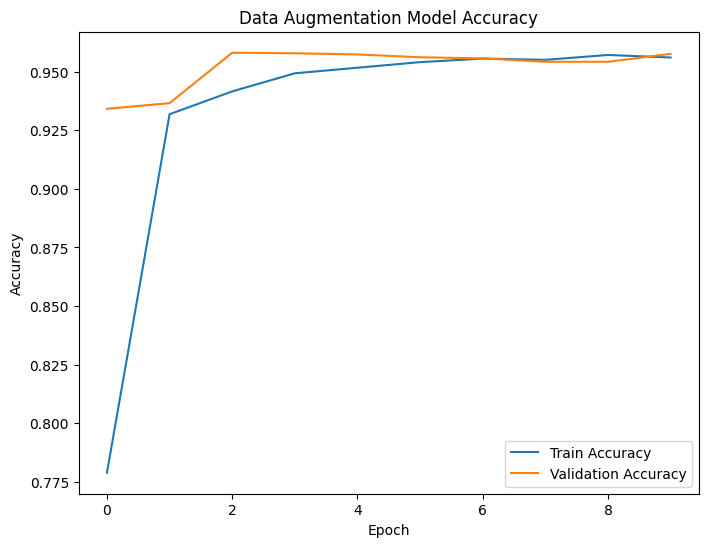

In [26]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Data Augmentation Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Transfer Learning Using MobileNetV2

Transfer learning allows us to leverage pre-trained models for better performance. We will use MobileNetV2 (pre-trained on ImageNet) as a feature extractor, followed by a custom classification head for malaria detection. Then, we compile the model.

In [27]:
# Use a pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model

# Build the transfer learning model
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

transfer_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Training the Transfer Learning Model

We train the transfer learning model in a similar fashion as before.

In [28]:
# Train the transfer learning model
history_transfer = transfer_model.fit(
    ds_train_aug,  # Using augmented data
    epochs=10,
    validation_data=ds_val,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.8897 - loss: 0.2663 - val_accuracy: 0.9216 - val_loss: 0.2085
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.9277 - loss: 0.1882 - val_accuracy: 0.9371 - val_loss: 0.1653
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.9313 - loss: 0.1817 - val_accuracy: 0.9427 - val_loss: 0.1607
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.9390 - loss: 0.1645 - val_accuracy: 0.9320 - val_loss: 0.1787
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.9399 - loss: 0.1688 - val_accuracy: 0.9318 - val_loss: 0.1773
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.9378 - loss: 0.1618 - val_accuracy: 0.9407 - val_loss: 0.1640


### Check Results

In this plot, we see the Validation Accuracy jumps up early, surpassing the Train Accuracy. However, it dips after a few epochs, which might indicate some instability during training. Still, the Train and Validation Accuracy stay relatively close, suggesting that this model, like the previous one, is doing a good job at generalizing and avoiding overfitting.

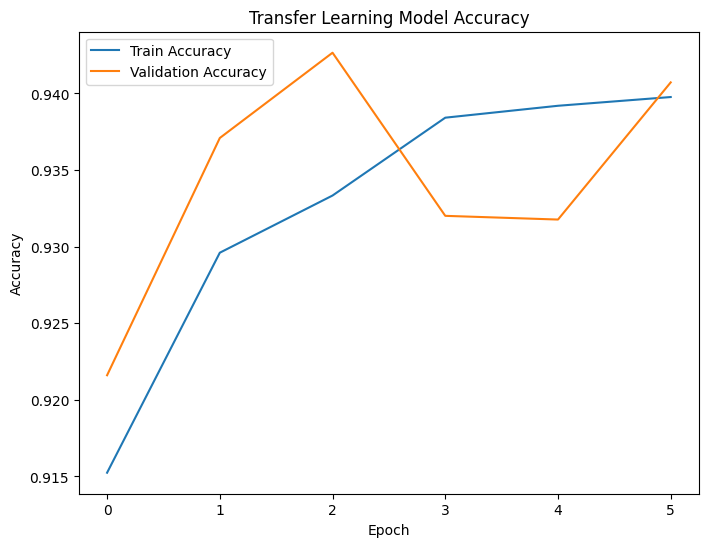

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Adding Dropout to the CNN Model

Dropout is a regularization technique to prevent overfitting. We will now build a CNN model with Dropout layers to randomly disable neurons during training.

In [30]:
# Build a CNN model with Dropout
def create_dropout_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

dropout_model = create_dropout_model()
dropout_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Dropout Model

In [34]:
dropout_model = create_dropout_model()
dropout_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history_dropout = dropout_model.fit(
    ds_train_aug,
    epochs=20,
    validation_data=ds_val,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.5732 - loss: 0.7909 - val_accuracy: 0.9153 - val_loss: 0.2731
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.9074 - loss: 0.3220 - val_accuracy: 0.9398 - val_loss: 0.1568
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.9358 - loss: 0.1901 - val_accuracy: 0.9519 - val_loss: 0.1542
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.9436 - loss: 0.1778 - val_accuracy: 0.9511 - val_loss: 0.1425
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9451 - loss: 0.1711 - val_accuracy: 0.9473 - val_loss: 0.1435
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.9493 - loss: 0.1616 - val_accuracy: 0.9516 - val_loss: 0.1496
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9490 - loss: 0.1606 - val_accuracy: 0.9511 - val_loss: 0.1443
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9509 - loss: 0.1630 - 

### Check Results

In this plot, both the Train and Validation Accuracy are very close throughout training, with little to no gap between them. This suggests that the dropout regularization is effectively preventing overfitting by keeping the model from becoming too specialized to the training data. The model is generalizing well to new, unseen data, as seen by the Validation Accuracy tracking the Train Accuracy closely.

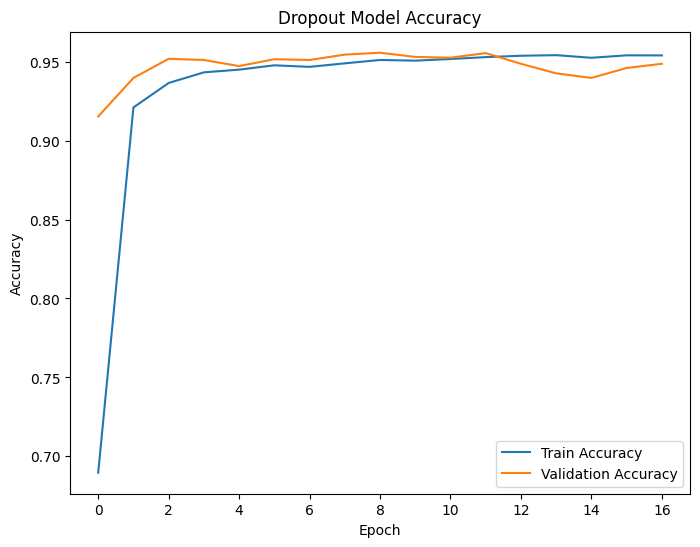

In [37]:
# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history_dropout.history['accuracy'], label='Train Accuracy')
plt.plot(history_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Dropout Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Putting It All Together: Combining All Techniques

In this section, we will combine all of the techniques we've discussed—**data augmentation**, **transfer learning**, and **dropout**—into one model to create a robust and powerful malaria detection system. This approach leverages the strengths of each technique:

1. **Data Augmentation** helps prevent overfitting by generating new training samples from the existing data.
2. **Transfer Learning** allows us to use a pre-trained model (such as MobileNetV2) that already learned useful features from a large dataset (ImageNet).
3. **Dropout** prevents overfitting by randomly disabling neurons during training, ensuring that the model does not rely too heavily on any particular set of features.
4. **Fine-Tuning** unfreezes some layers of the pre-trained model to allow further training on the Malaria dataset, adapting the base model more closely to our specific task.

### Step 1: Build the Combined Model

We start by defining a transfer learning model using **MobileNetV2** as the base. We will then add **data augmentation**, **dropout**, and a custom classification head for binary classification.

In [42]:
# Define the data augmentation layer without specifying input shape in Sequential
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Use a pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,  # Exclude the top layers
                         weights='imagenet')

# Freeze the base model initially
base_model.trainable = False

# Build the full model
combined_model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Define input shape here
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
combined_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Summarize the model
combined_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Step 2: Train the Combined Model

We now train this model using the augmented training data. Since we are using transfer learning, the base model (MobileNetV2) is initially frozen, so we only train the custom classification head.

In [43]:
# Train the combined model
history_combined = combined_model.fit(
    ds_train_aug,  # Using augmented data
    epochs=10,
    validation_data=ds_val,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 52s 78ms/step - accuracy: 0.8541 - loss: 0.3506 - val_accuracy: 0.9114 - val_loss: 0.2208
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 77ms/step - accuracy: 0.9166 - loss: 0.2265 - val_accuracy: 0.9134 - val_loss: 0.2182
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.9236 - loss: 0.2186 - val_accuracy: 0.9289 - val_loss: 0.1857
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.9242 - loss: 0.2092 - val_accuracy: 0.9366 - val_loss: 0.1811
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.9257 - loss: 0.2027 - val_accuracy: 0.9110 - val_loss: 0.2147
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 77ms/step - accuracy: 0.9308 - loss: 0.1966 - val_accuracy: 0.9402 - val_loss: 0.1672
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.9309 - loss: 0.1923 - val_accuracy: 0.9264 - val_loss: 0.1913
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9342 - loss: 0.1898 - 

### Step 3: Fine-Tuning the Model

After training the custom head, we can fine-tune some of the layers in the pre-trained base model. Fine-tuning helps adapt the pre-trained model more closely to the malaria detection task.

In [44]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Compile the model with a lower learning rate for fine-tuning
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Fine-tune the model
history_finetune = combined_model.fit(
    ds_train_aug,
    epochs=10,
    validation_data=ds_val,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 240s 347ms/step - accuracy: 0.8622 - loss: 0.3475 - val_accuracy: 0.9158 - val_loss: 0.2156
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 206s 339ms/step - accuracy: 0.9342 - loss: 0.1898 - val_accuracy: 0.8952 - val_loss: 0.2915
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 201s 332ms/step - accuracy: 0.9435 - loss: 0.1735 - val_accuracy: 0.9439 - val_loss: 0.1734
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 201s 332ms/step - accuracy: 0.9466 - loss: 0.1599 - val_accuracy: 0.9480 - val_loss: 0.1534
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 200s 331ms/step - accuracy: 0.9547 - loss: 0.1402 - val_accuracy: 0.9504 - val_loss: 0.1359
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 200s 332ms/step - accuracy: 0.9520 - loss: 0.1391 - val_accuracy: 0.9489 - val_loss: 0.1501
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 200s 331ms/step - accuracy: 0.9576 - loss: 0.1299 - val_accuracy: 0.9519 - val_loss: 0.1495
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 200s 330ms/step - accuracy: 0.9547 -

### Step 4: Evaluate the Final Model on the Test Set

Finally, after training and fine-tuning, we evaluate the model on the test set to get an estimate of its performance on unseen data.

In [45]:
# Evaluate the transfer learning model on the test set
test_loss, test_accuracy = combined_model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9444 - loss: 0.1560
Test Accuracy: 0.95


In [48]:
! pip install scikit-learn

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 23.8 MB/s eta 0:00:00 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


## Evaluating Combined Model Performance with F1 Score

To further evaluate the performance of our model, we computed the **F1 score**, a metric that balances **precision** and **recall**. This is particularly useful for imbalanced datasets. Using the `sklearn.metrics` library, we generated predictions from the test set, compared them with the true labels, and calculated the F1 score.

In [49]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Step 1: Predict on the test dataset
y_true = []
y_pred = []

for images, labels in ds_test:  # Iterate through the test set
    preds = combined_model.predict(images)
    y_true.append(labels.numpy())  # Ground truth labels
    y_pred.append((preds > 0.5).astype(int))  # Predictions (threshold at 0.5)

# Step 2: Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Step 3: Calculate F1 score
f1 = f1_score(y_true, y_pred)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Optionally: Print full classification report (precision, recall, f1-score, etc.)
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

2024-09-17 17:49:53.386686: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Results:

The model achieved a high F1 score of 0.95, indicating strong predictive performance on both positive and negative classes. Below is the complete classification report:

## Visualizing Model Predictions

After training and evaluating the model, it’s important to visualize the predictions on test images. Below, we display a batch of images from the test set, showing both the **true labels** and the **predicted labels** for each image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


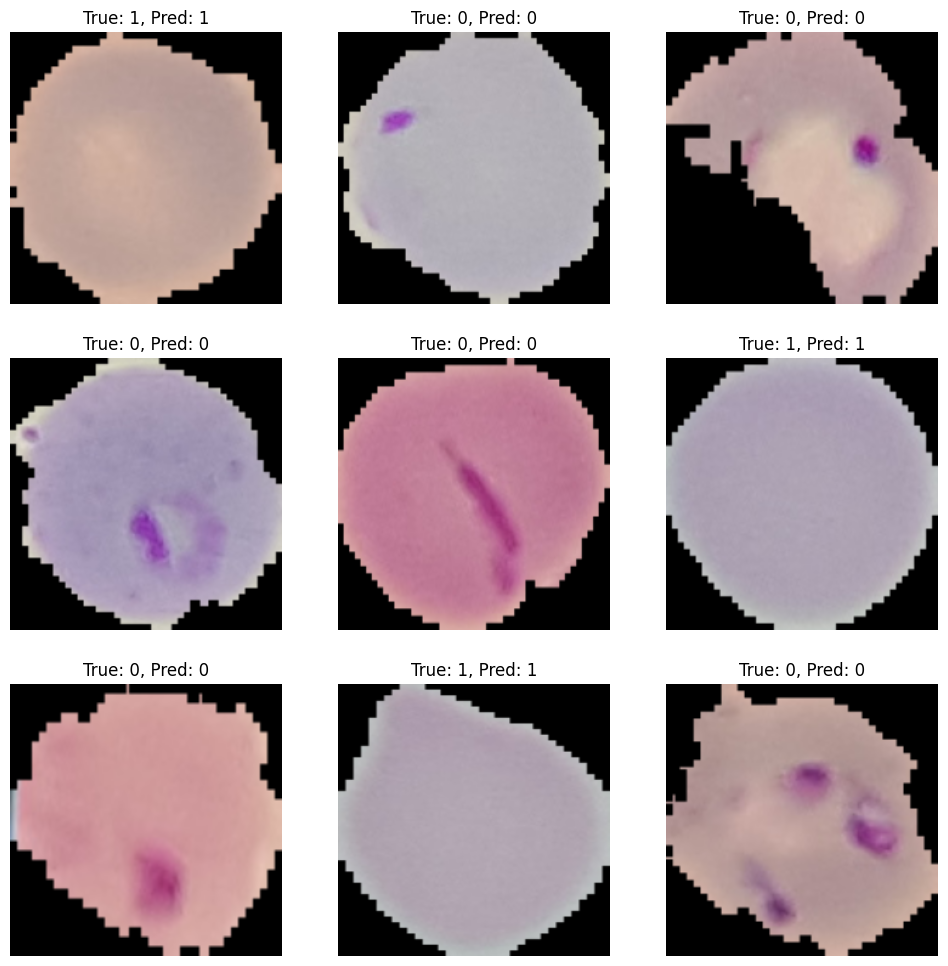

In [51]:
# Get a batch of test images and labels
test_images, test_labels = next(iter(ds_test))

# Predict
predictions = combined_model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

# Plot some images with predictions
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {int(test_labels[i].numpy())}, Pred: {predicted_labels[i]}")
    plt.axis("off")
plt.show()

### Results

In the above grid, each image is labeled with its True Label and Predicted Label. This visualization helps assess the model’s performance qualitatively, providing insight into how well the model is distinguishing between infected (1) and uninfected (0) cells.

## Conclusion

In this tutorial, we successfully built and trained a deep learning model to classify malaria-infected and healthy cell images. We started by building a baseline CNN model and progressively improved its performance through data augmentation, transfer learning with MobileNetV2, and regularization using dropout layers. Along the way, we evaluated the model using key metrics like accuracy, F1 score, and visualized the predictions to understand its behavior better.

### Key Takeaways:
- **Data Augmentation**: Helped improve generalization by creating diverse training samples.
- **Transfer Learning**: Leveraging a pre-trained MobileNetV2 model significantly boosted performance, saving time and computational resources.
- **Model Regularization**: Dropout was crucial in preventing overfitting, further enhancing model generalization.
- **Evaluation**: The use of metrics like the F1 score, precision, and recall provided deeper insight into the model’s performance, especially in an imbalanced dataset scenario.

### Next Steps:
If you’d like to extend this project further, here are a few ideas:
- **Fine-Tune the Pre-trained Model**: Unfreeze more layers of the pre-trained MobileNetV2 and fine-tune them on the Malaria dataset.
- **Try Other Architectures**: Experiment with other pre-trained models like ResNet or EfficientNet to see if they yield even better results.
- **Optimize Hyperparameters**: Tuning learning rates, batch sizes, and the architecture could lead to further improvements.

Thank you for following along with this tutorial. We hope it gave you a solid foundation in building image classification models using TensorFlow and advanced techniques like transfer learning. Keep experimenting and happy coding!